See 0_wget_files.ipynb and 1_Install_Grizli.ipynb for instructions on getting the files used here and installing grizli.

Full Process Outline
------------------------
1) Install Grizli

2) Install pysynphot and WebbPSF
- Download Phoenix stellar atlas and set PYSYN_CDBS in .bashrc as detailed in pysynphot install instructions

3) Get files from products site
- Config files (Roman*.conf and sens_0720_2020.fits)
- Direct Image (GRS_*_direct_final.fits)
- Catalog (MOT_*_cut_uncut.txt)
- SEDs (I've zipped the SEDs we need for this notebook as this link: https://drive.google.com/file/d/1XWcQAeOIskuybYT92NrScj5Jt64C29kW/view?usp=sharing)

4) Prepare the fits files
- Modify header to include instrument, detector, and config file information
- Rotate 90 degrees counter-clockwise (270 degress clockwise using np.rot90)

5) Simulate

Psuedocode Outline of this notebook
-----
1) Prepare the direct image fits files
- Modify the header
- Rotate the image
- Save fits file locally

2) Build and save empty segmentation fits file

3) Simulate
- Read in MOT Catalog
- Define equations to determine object shape on the seg map.
- Pre-load star spectrum & Instantiate Bandpass object
- Instantiate GrismFLT object
- for-loop
    - Read object characteristics
    - Define object shape on segmentation map and set seg map
    - Read in and adjust Object Spetrum (if not a star)
    - Pass all into Grizli, compute_model_orders

4) Save & Display model

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (16,7) # big images
mpl.rcParams["image.interpolation"] = "nearest" # no smoothing/blurring
mpl.rcParams["image.origin"] = "lower" 

from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import os

# Spectra tools
import pysynphot as S
import webbpsf

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
os.chdir("/Users/keith/astr/research_astr/summer-roman-project/0) tutorial/fits_files") # change to directory containing your fits files
direct_fits = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
ready_fits = "ready_direct_{0}".format(direct_fits)
empty_seg = "empty_seg.fits"

## 1) Prepare the direct image fits files
1) Add information to the header
2) Rotate the image 270 degrees clockwise
3) Save modified fits

In [3]:
file = fits.open(direct_fits)

file[1].data = np.rot90(file[1].data, k=3) # np.rot90 rotates clockwise k times

file[0].header["INSTRUME"] = "ROMAN"
file[0].header["FILTER"] = "d1_"
file[1].header["CONFFILE"] = "./Roman.det1.07242020.conf" # This had to be a path, not just a filename; otherwise, grizli can't find the sensitivity fits

file.writeto(ready_fits, overwrite=True)

header = file[1].header # We need to copy this header info into the segmentation file

file.close()

## 2) Build and save empty segmentation fits file

In [4]:
empty_array = np.zeros((4088,4088)) # 4088x4088 detector shape
fits.writeto(empty_seg, data=empty_array, header=header, overwrite=True)

## 3) Simulate
- Read in MOT Catalog

In [5]:
hlss_tbl = Table.read("MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt", format="ascii")

# I seperate the table by Stars and Galaxies, and sort each part so the faintest objects are handled first
# It was important when putting everything on one segmentation image; Sorting first meant that when a pixel was occupied by multiple objects,
# the flux at that pixel was attribute to the birghtest object. Our new method doesn't need to break ties like this.
hlss_tbl = hlss_tbl.group_by("MODIMAGE") # Seperates stars from galaxies
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True) 

- Define equations to determine object shape on the seg map.

In [6]:
# Prepare shape-defining equations
# GALAXY generic ellipse shape
A = lambda theta, a, b: ((np.sin(theta)**2)/(a**2)) + ((np.cos(theta)**2)/(b**2))
B = lambda theta, a, b: 2 * np.sin(theta) * np.cos(theta) * ((1/b**2) - (1/a**2))
C = lambda theta, a, b: ((np.sin(theta)**2)/(b**2)) + ((np.cos(theta)**2)/(a**2))

gen_ellipse = lambda x, y, x_0, y_0, ell: (A(*ell) * (x - x_0)**2) + (B(*ell) * (x - x_0) * (y - y_0)) + (C(*ell) * (y - y_0)**2)

# STAR generic circle shape
gen_circle = lambda x, y, x_0, y_0: (x-x_0)**2 + (y-y_0)**2

- Pre-load star spectrum & Instantiate Bandpass object

In [7]:
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs" # Change to your path to directory containing SEDs

# Read in star spectrum
src = webbpsf.specFromSpectralType("G0V", catalog="phoenix")
wave = np.linspace(10000, 20000, 10000)
flux = src(wave).value
star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstroms", fluxunits="flam")

# Create F158 Filter Bandpass object
df = Table.read(os.path.join(SED_dir, "wfirst_wfi_f158_001_syn.fits"), format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

del wave
del flux
del df

- Instantiate GrismFLT object

In [8]:
from grizli.model import GrismFLT

pad = 100 # Objects near the edge of the detector may have a trace with a center of the detector. Padding ensures it will still disperse
roman = GrismFLT(direct_file=ready_fits, seg_file=empty_seg, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


- for-loop
    - Read object characteristics
    - Define object shape on segmentation map and set seg map
    - Read in and adjust Object Spetrum (if not a star)
    - Pass all into Grizli, compute_model_orders

In [9]:
# If an object is too small and doesn't have an integer solution to it's equation, it'll print an error.
# Sometimes, I catch those errors in the segmentation map making phase and write them to a seperate file.

error_file = open("errors.txt", "w")

for object in tqdm(hlss_tbl):

    id = object["NUMBER"]
    mag = object["MAG_F1500W"]
    _is_star = object["MODIMAGE"]
    x_0 = object["X_IMAGE"] + 100 # Add 100 to account for padding
    y_0 = object["Y_IMAGE"] + 100 

    # SEGMENTATION MAPMAKING
    # ----------------------------------------------------------

    # Define STAR shape solution
    if _is_star:
        
        # Set radius and specific star-shape
        radius = 40 
        circ = lambda x, y: gen_circle(x, y, x_0, y_0) <= (radius ** 2) # faster to compare squares than sqrt (I think)

        # Define cutout bounds
        x_min = max(int(x_0 - radius + 1), 0)       # max/min ensures we stay on the detector (plus padding)
        x_max = min(int(x_0 + radius + 1), 4288)    # The +1 is so we've got a bit of padding, to ensure our cutout's not rounding down too far
        y_min = max(int(y_0 - radius + 1), 0)
        y_max = min(int(y_0 + radius + 1), 4288)

        # Create Meshgrid within bounds
        x = np.arange(x_min, x_max)
        y = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x, y)

        condition = circ(x_grid, y_grid)
    
    # Define GALAXY shape solution
    else:

        # Read extra ellipse info
        a = object["A_IMAGE"] # semi-major axis
        b = object["B_IMAGE"] # semi-minor axis
        theta = object["THETA_IMAGE"] * (np.pi / 180) # theta in radians
        ell = (theta, a, b)

        # Set radius and specific ellipse shape (radius isn't the right word, but it's effectively the same)
        radius = 4
        ellipse = lambda x, y: gen_ellipse(x, y, x_0, y_0, ell) <= (radius ** 2)

        # Define cutout bounds
        x_min = max(int(x_0 - (radius * a) + 1), 0)     # Very similar to above cutout method; (radius * a) give the largest possible dimension
        x_max = min(int(x_0 + (radius * a) + 1), 4288)
        y_min = max(int(y_0 - (radius * a) + 1), 0)
        y_max = min(int(y_0 + (radius * a) + 1), 4288)

        # Create Meshgrid within bounds
        x = np.arange(x_min, x_max)
        y = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x, y)

        condition = ellipse(x_grid, y_grid)

    temp_seg = np.zeros((4288,4288), dtype="float32") # Grizli expects arrays to have dtype="float32"
    temp_seg[y_min:y_max, x_min:x_max][np.where(condition)] = id

    # Uncomment this is writing not-in-seg-map errors to a seperate file
    if not np.any(temp_seg):
        error_file.write("ID {0} not in temp_seg \n".format(id))
        continue

    roman.seg = np.rot90(temp_seg, k=3) # temp_seg is built using non-rotated coordinates; rotate temp_seg so it lines up with our rotated direct image

    # SIMULATION
    # ----------------------------------------------------------

    # STAR
    if _is_star:
        
        # Adjust spectrum scale using F158 Filter Bandpass object and star magnitude
        spec = star_spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

    # GALAXY
    else: 

        # Read in unique Galaxy Spectrum
        sed_path = os.path.join(SED_dir, "SED:rest:gal.{0}.fits".format(object["SPECTEMP"]))
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        z = object["Z"]

        spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
        spec = spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

    # By default, grizli trys to compute a cutout size. This cutout size is not large enough for the roman grism.
    # In 4) FOV0_sims/notebooks/dy-by-optimize.ipynb, I estimate the maximum needed size to be 77 for detector 1.
    # See that notebook for more details
    roman.compute_model_orders(id=id, mag=mag, compute_size=False, size=77, in_place=True, store=False,
                               is_cgs=True, spectrum_1d=[spec.wave, spec.flux])

100%|██████████| 10763/10763 [11:29<00:00, 15.61it/s]


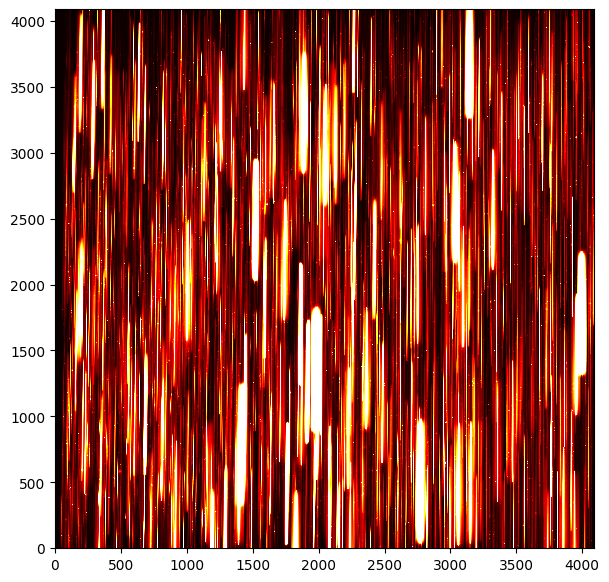

In [14]:
# Dispersed model is still rotated; We have to rotate it back
upright_img = np.rot90(roman.model[pad:-pad, pad:-pad])

plt.imshow(upright_img, vmin=0, vmax=0.11738539732765789, cmap="hot") # this vmax works well on the grism sim products